In [2]:
using Zygote, LinearAlgebra, Flux, Statistics, Images, Random, CUDA, Plots, Distributions, StatsAPI
ENV["DATADEPS_ALWAYS_ACCEPT"] = true
using MLDatasets, MLUtils
train_x, train_y = MNIST.traindata(Float32)
test_x, test_y = MNIST.testdata(Float32)
TX = train_x |> flatten
tX = test_x |> flatten
rs(x, y) = w -> reshape(w, (x, y))
data = DataLoader((TX, TX), batchsize=200, shuffle=true)
axis(x) = D -> [D[[k != x ? (:) : i for k in 1:length(size(D))]...] for i in axes(D, x)]

┌ Warning: MNIST.traindata() is deprecated, use `MNIST(split=:train)[:]` instead.
└ @ MLDatasets C:\Users\bhatn\.julia\packages\MLDatasets\bg0uc\src\datasets\vision\mnist.jl:187


┌ Warning: MNIST.testdata() is deprecated, use `MNIST(split=:test)[:]` instead.
└ @ MLDatasets C:\Users\bhatn\.julia\packages\MLDatasets\bg0uc\src\datasets\vision\mnist.jl:195


axis (generic function with 1 method)

In [3]:
toint(x) = floor(x) |> Int
layers = [2, 1.4, 1.2, 1]
w1 = (28 .^ layers[1:end-1]) .|> toint
w2 = (28 .^ layers[2:end]) .|> toint
encoder = Chain(
    Dense(w1[1], w2[1], selu),
    Dense(w1[2], w2[2], selu),
    Dense(w1[3], w2[3], sigmoid),
) |> gpu
decoder = Chain(
    Dense(w2[3], w1[3], selu),
    Dense(w2[2], w1[2], selu),
    Dense(w2[1], w1[1], sigmoid),
) |> gpu

Chain(
  Dense(28 => 54, selu),                # 1_566 parameters
  Dense(54 => 106, selu),               # 5_830 parameters
  Dense(106 => 784, σ),                 # 83_888 parameters
)                   # Total: 6 arrays, 91_284 parameters, 856 bytes.

In [4]:
loss = Flux.binarycrossentropy
opt = ADAM(0.01)
p = Flux.params(Chain(encoder, decoder))
for epoch in 1:20
    println("Epoch: $epoch")
    for (x_batch, y_batch) in data
        gpx = x_batch |> gpu
        gpy = y_batch |> gpu
        gs = gradient(p) do
            z = encoder(gpx)
            loss(decoder(z), gpy)
        end
        Flux.Optimise.update!(opt, p, gs)
    end
end

Epoch: 1


Epoch: 2


Epoch: 3


Epoch: 4


Epoch: 5


Epoch: 6


Epoch: 7


Epoch: 8


Epoch: 9


Epoch: 10


Epoch: 11


Epoch: 12


Epoch: 13


Epoch: 14


Epoch: 15


Epoch: 16


Epoch: 17


Epoch: 18


Epoch: 19


Epoch: 20


In [5]:
encdec = Chain(encoder, decoder) |> cpu
Flux.kldivergence(encdec(tX), tX)

15.283661f0

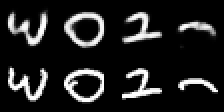

In [6]:
iS = rand(1:1000, 4)
[reduce(hcat, [encdec(TX[:, i])' |> rs(28, 28) for i in iS]); reduce(hcat, [TX[:, i]' |> rs(28, 28) for i in iS])] .|> Gray

In [7]:
T = 10
mag_e = 5
diffuser = Chain(Flux.Bilinear((mag_e, 28) => 28, selu), Dense(28, 28, selu), Dense(28, 28, selu), Dense(28, 28, sigmoid)) |> gpu
t_emb = Embedding(T, mag_e) |> gpu
loss = Flux.binarycrossentropy
opt = Adam(0.01)
α = 0:1/(T - 1):1
p = Flux.params(Chain(t_emb, diffuser))
train_z = encoder(TX) |> cpu # encoded training data
batch_size = 625
for _ in 1:20
    t = rand(1:T)
    
end

ArgumentError: ArgumentError: cannot take the CPU address of a CuArray{Float32, 2, CUDA.Mem.DeviceBuffer}

In [8]:
cdif = diffuser |> cpu
dec = decoder |> cpu
cembed = t_emb |> cpu
R(x, t) = cdif((cembed(ones(Int64, size(x, 2)) * t), x))

R (generic function with 1 method)

In [9]:
encs = encoder(TX |> gpu) |> cpu
# mvbetadist = Distributions.Product(encs |> axis(1) .|> x -> fit_mle(Beta, x))
mvnormdist = Distributions.Product(encs |> axis(1) .|> x -> fit_mle(Normal, x))

Product{Continuous, Normal{Float64}, Vector{Normal{Float64}}}(
v: Normal{Float64}[Normal{Float64}(μ=0.9999993443489075, σ=3.301697246585447e-5), Normal{Float64}(μ=0.9999999403953552, σ=9.09423723116811e-6), Normal{Float64}(μ=0.8715893626213074, σ=0.22656694499949953), Normal{Float64}(μ=0.48728761076927185, σ=0.2070569952545776), Normal{Float64}(μ=0.9999999403953552, σ=9.05896985086156e-6), Normal{Float64}(μ=0.49656185507774353, σ=0.249704732861196), Normal{Float64}(μ=0.4220190942287445, σ=0.20656425317586818), Normal{Float64}(μ=0.9999999403953552, σ=8.96173798663619e-6), Normal{Float64}(μ=0.43043753504753113, σ=0.19696217894533924), Normal{Float64}(μ=0.5069789290428162, σ=0.19254340140804943)  …  Normal{Float64}(μ=0.5334770083427429, σ=0.2487103618177595), Normal{Float64}(μ=0.46822959184646606, σ=0.25094298879686217), Normal{Float64}(μ=0.8405230641365051, σ=0.23999468479628616), Normal{Float64}(μ=0.49026671051979065, σ=0.19667349765789385), Normal{Float64}(μ=0.417830228805542, σ=0.1937

In [10]:
function sample_d(n)
    x = rand(28, n, T)
    for s in 2:1:T
        xh_o = R(x[:,:,s], s)
        x[:, :, s-1] = D(xh_o, s - 1)
    end
    return R(x[:, :, T], 1)
end

sample_d (generic function with 1 method)

In [1]:
h = 10
sample_d(h)

UndefVarError: UndefVarError: `sample_d` not defined

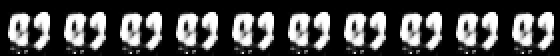

In [146]:
R(D(rand(mvnormdist, h), 4) , 2) |> dec |> rs(28, 28*h) .|> Gray

In [71]:
fm = Chain(encoder, diffuser, decoder) |> cpu
Flux.kldivergence(fm(tX), tX)

LoadError: DimensionMismatch: number of rows in data must match W

In [ ]:
iS = rand(1:1000, 4)
[reduce(hcat, [fm(TX[:, i])' |> rs(28, 28) for i in iS]); reduce(hcat, [TX[:, i]' |> rs(28, 28) for i in iS])] .|> Gray

In [ ]:
encs = encoder(TX |> gpu) |> cpu
mvbetadist = Distributions.Product(encs |> axis(1) .|> x -> fit_mle(Beta, x))
mvnormdist = Distributions.Product(encs |> axis(1) .|> x -> fit_mle(Normal, x))

In [262]:
dd = Chain(diffuser, decoder) |> cpu
d = Chain(decoder) |> cpu

Chain(
  Chain(
    Dense(28 => 54, selu),              # 1_566 parameters
    Dense(54 => 106, selu),             # 5_830 parameters
    Dense(106 => 784, σ),               # 83_888 parameters
  ),
)                   # Total: 6 arrays, 91_284 parameters, 357.047 KiB.

In [312]:
sum(encs |> axis(2) .|> x -> loglikelihood(mvbetadist, x)), sum(encs |> axis(2) .|> x -> loglikelihood(mvnormdist, x))

(380054.44f0, 266174.6661939353)

In [320]:
Flux.kldivergence(rand(mvbetadist, 10000) |> dd, tX), Flux.kldivergence(rand(mvbetadist, 10000) |> d, tX)

(287.6242259329252, 400.74370652423073)

In [323]:
Flux.kldivergence(rand(mvnormdist, 10000) |> dd, tX), Flux.kldivergence(rand(mvnormdist, 10000) |> d, tX)

(286.9530572800221, 406.0179387169956)

In [324]:
Flux.kldivergence(rand(28, 10000) |> dd, tX), Flux.kldivergence(rand(28, 10000) |> d, tX)

(367.9909379200449, 524.0393653389146)

In [325]:
Flux.kldivergence(randn(28, 10000) |> dd, tX), Flux.kldivergence(randn(28, 10000) |> d, tX)

(547.6425734023377, 836.1168753124942)

In [326]:
Flux.kldivergence(rand(Beta(), 28, 10000) |> dd, tX), Flux.kldivergence(rand(Beta(),28, 10000) |> d, tX)

(369.5001151062365, 526.2097914160381)